In [18]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
sys.path.append("../dep/breze")

In [2]:
tracks = json.load(open("../data/groundtruth_tracks.json"))

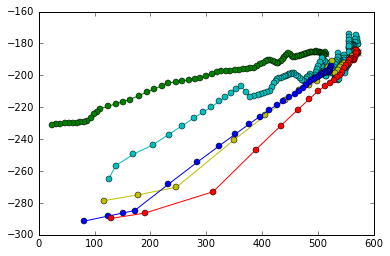

In [3]:
def displayTracks(tracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        track = np.array(tracks.items()[i][1])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o")
displayTracks(tracks, 5)

In [155]:
import pandas
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
np.random.seed(7)

In [6]:
def buildLookbackDataset(tracks, lookback=3):
    lookback +=1
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            dataset.append(np.array(track[i-lookback:i]).ravel())
    return dataset
                
dataset = buildLookbackDataset(tracks) 
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted

In [7]:
# Ignore for now
# dset = np.zeros((25002,8))
# for i in xrange(25002):
#     dset[i,:] = dataset[i]

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [99]:
# Split into test and train
train_size = int(len(dataset) * .01)#0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(250, 24752)


In [100]:
xtrain = np.matrix(train[:,0:6])
ytrain = np.matrix(train[:,6:])
xtest = np.matrix(test[:,0:6])
ytest = np.matrix(test[:,6:])

In [101]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 3, 2))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 3, 2))

In [102]:
xtrain[0].shape


(3, 2)

In [179]:
import os
os.environ["THEANO_FLAGS"] = 'optimizer=None,exception_verbosity=high'
import theano
reload(theano)
import theano.tensor as T
from theano import printing
from theano.tensor.nlinalg import Det, AllocDiag

In [104]:
from breze.learn.utils import theano_floatx
from breze.arch.component.distributions.mvn import pdf 

In [91]:
def custom_objective(y_true, y_pred):
    pred = y_pred[:,0:2].reshape((2,1))
    cov = y_pred[:,2:6].reshape((2,2))
    mu = y_true[:,0:2].reshape((2,1))
    
    #clipping
    cov[0,0].clip(0,1)
    cov[0,1].clip(-1,1)
    cov[1,0].clip(-1,1)
    cov[1,1].clip(0,1)
    
    diff = pred - mu
    dot1 = T.dot(diff.T, T.inv(cov))
    dot2 = T.dot(dot1, diff)
    tmp = -(dot2)/2
    prob = T.exp(tmp)
    det = Det()
    det_res = T.sqr(det(2* np.pi * cov))
    #num_print = printing.Print('num')
    #prob = num_print(prob)
    #den_print = printing.Print('den')
    #det_res = den_print(det_res)
    prob = prob / det_res
    #print_op = printing.Print('prob')
    #printed_prob = print_op(prob)
    #ret = 1-printed_prob
    return prob

In [108]:
def custom_objective(y_true, y_pred):
    pred = y_pred[:,0:2].reshape((1,2))
    cov = y_pred[:,2:6].reshape((2,2))
    mu = y_true[:,0:2].ravel()
    
    #p_print = printing.Print('cov')
    #cov = p_print(cov)
    psd = T.dot(cov, cov.T)
    #psd_print = printing.Print('psd')
    #psd = psd_print(psd)
    
    #clipping
    #cov[0,0].clip(0,1)
    #cov[0,1].clip(-1,1)
    #cov[1,0].clip(-1,1)
    #cov[1,1].clip(0,1)
    p = pdf(pred, mu, psd)
    #p_print = printing.Print('shape')
    #shape = p_print(p.shape)
    return p #+ shape * 0

In [146]:
def custom_objective(y_true, y_pred):
    pred = y_pred[:,0:2].reshape((1,2))
    cov = y_pred[:,2:6].ravel()
    mu = y_true[:,0:2].ravel()
    
    #psd = T.concatenate((cov[0:2], cov[1:3])).reshape((2,2))
    cov = cov * 0 +1
    psd = cov.reshape((2,2))*[[1, 0],[0, 1]]
    #clipping
    #psd[0,0].clip(0,1)
    #psd[0,1].clip(-1,1)
    #psd[1,0].clip(-1,1)
    #psd[1,1].clip(0,1)
    #p_print = printing.Print('shape')
    #psd = p_print(psd)
    p = pdf(pred, mu, psd)
    #prob_print = printing.Print('prob')
    #p = prob_print(p)
    return -p #+ shape * 0

In [218]:
# Try to predict cov matrix
def custom_objective(y_true, y_pred):
    pred = y_pred[:,0:2].reshape((1,2))
    cov = y_pred[:,2:8].ravel()
    mu = y_true[:,0:2].ravel()
    
    #cov = cov.clip(0.001,1)
    Q = cov[0:4].reshape((2,2))
    #D = T.dot(cov[4:6].reshape((2,1)), T.eye(2))
    diag = AllocDiag()
    D = diag(cov[4:6].clip(0.0001, 1))
    
    pd = T.dot(T.dot(Q.T, D), Q)
    #printer = printing.Print('shape')
    #pd = printer(pd)
    p = pdf(pred, mu, pd)
    #printer = printing.Print('prob')
    #p = printer(p)
    return 1.-p 

In [222]:
model = Sequential()
model.add(LSTM(4, input_shape=(3,2)))
model.add(Dense(8))
adam = keras.optimizers.Adam(lr=0.01)
model.compile(loss=custom_objective, optimizer='adam')
model.fit(xtrain, ytrain, nb_epoch=1, batch_size=1, verbose=2)

Epoch 1/1
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]
prob __str__ = [ 0.]


LinAlgError: 2-th leading minor not positive definite
Apply node that caused the error: Cholesky{lower=True, destructive=False}(MatrixInverse.0)
Toposort index: 148
Inputs types: [TensorType(float32, matrix)]
Inputs shapes: [(2, 2)]
Inputs strides: [(8, 4)]
Inputs values: [array([[  1.01212742e+11,   4.66793038e+11],
       [  4.66793071e+11,   2.15284921e+12]], dtype=float32)]
Outputs clients: [[CholeskyGrad{lower=True, destructive=False}(MatrixInverse.0, Cholesky{lower=True, destructive=False}.0, CGer{destructive}.0), Dot22Scalar(Elemwise{sub,no_inplace}.0, Cholesky{lower=True, destructive=False}.0, TensorConstant{2.0}), InplaceDimShuffle{1,0}(Cholesky{lower=True, destructive=False}.0), CGemv{inplace}(AllocEmpty{dtype='float32'}.0, TensorConstant{1.0}, Cholesky{lower=True, destructive=False}.0, Elemwise{Mul}[(0, 0)].0, TensorConstant{0.0})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/daniter/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/daniter/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-222-3a60c807053d>", line 5, in <module>
    model.compile(loss=custom_objective, optimizer='adam')
  File "/Users/daniter/anaconda2/lib/python2.7/site-packages/keras/models.py", line 339, in compile
    **kwargs)
  File "/Users/daniter/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 588, in compile
    sample_weight, mask)
  File "/Users/daniter/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 311, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-218-c90461787b8c>", line 16, in custom_objective
    p = pdf(pred, mu, pd)
  File "../dep/breze/breze/arch/component/distributions/mvn.py", line 70, in pdf
    L = chol(inv_cov)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [217]:
trainPredict = model.predict(xtrain)
print xtrain[0]
print ytrain[0]
print trainPredict[0]

[[ 0.62446123  0.09930999]
 [ 0.62646688  0.09784558]
 [ 0.62939047  0.09337126]]
[[ 0.63313688  0.09231694]]
[-0.02006117 -0.21650271  0.27322388 -0.03192183 -0.11148317  0.26713473
  0.09701332 -0.00552071]


In [ ]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)
print trainPredict.shape
# invert predictions
#trainPredict = scaler.inverse_transform(np.concatenate((xtrain.reshape(xtrain.shape[0], xtrain.shape[2]),trainPredict), axis=1))[:,2:]
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.7f RMSE' % (testScore))

In [ ]:
scaledPredictTrain = scaler.inverse_transform(np.concatenate((ytrain,trainPredict,ytrain,trainPredict), axis=1))
scaledPredictTest = scaler.inverse_transform(np.concatenate((ytest,testPredict,ytest,testPredict), axis=1))

trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,0:2], scaledPredictTrain[:,2:4]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,0:2], scaledPredictTest[:,2:4]))
print('Test Score: %.7f RMSE' % (testScore))

print ytrain.shape

In [ ]:
#print model.predict(np.array(tracks.items()[0][1][0]).reshape(1,1,2))
print tracks.items()[0][1][0]
print tracks.items()[0][1][1]

In [ ]:
print np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
orig_scale=np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
l = scaler.transform(orig_scale)
print l
#x = l[0:2].reshape(1,1,2)
#y = l[2:]

In [ ]:
# Note this will predict the new point one frame ahead and build a track by 
# using measurements from the previous measurement.
# The first prediction is exactly the first measurement
# The last prediction is emitted because we know that the object is gone
# but currently the model has no method for predicting the death of an object
def rebuildTracks(tracks, model):
    predTracks = {}
    for track in tracks.items():
        predTracks[track[0]] = []
        t = predTracks[track[0]]
        for i, pos in enumerate(track[1]):
            if i < 3:
                t.append(pos)
            else:
                # scale and resize
                p1 = track[1][i-3]
                p2 = track[1][i-2]
                p3 = track[1][i-1]
                p = scaler.transform(np.array(p1+p2+p3+p3).reshape(1,-1))[0][0:6].reshape(1,3,2)
                # predict
                pred = model.predict(p).reshape(1,2).tolist()
                pred = scaler.inverse_transform(np.array(pred[0]+pred[0]+pred[0]+pred[0])\
                                                .reshape(1,-1))[0][0:2]
                t.append(pred)
    return predTracks

In [ ]:
predictedTracks = rebuildTracks(tracks,model)

In [ ]:
def displayPredictedTracks(tracks,predictedTracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        if i / float(len(tracks.items())) < .67:
            print "Training"
        else:
            print "Testing"
        print "%d of %d"% (i, len(tracks.items()))
        key = tracks.items()[i][0]
        track = np.array(tracks.items()[i][1])
        t2 = np.array(predictedTracks[key])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o", color='b')
        plt.plot(t2[:,0], -t2[:,1], marker="s", color='r')


In [ ]:
displayPredictedTracks(tracks,predictedTracks, 1)

In [223]:
def covariance(tracks, predTracks):
    x = []
    y = []
    for (key, track) in tracks.items():
        for j, point in enumerate(track):
            x.append(point[0] - predictedTracks[key][j][0])
            y.append(point[1] - predictedTracks[key][j][1])
    x = np.matrix(x)
    y = np.matrix(y)
    m = np.concatenate((x,y), axis=0)
    print np.var(x)
    print np.var(y)
    return np.cov(m)

In [224]:
print covariance(tracks, predictedTracks)

NameError: name 'predictedTracks' is not defined